## Unconditional score based diffusion model

In [ ]:
# Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


In [ ]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Load and Normalize
df = pd.read_csv("weatherHistory.csv", parse_dates=["Formatted Date"])
df = df.sort_values("Formatted Date").reset_index(drop=True)
feature = "Temperature (C)"

scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[[feature]])

#  Create windows
WINDOW_SIZE = 720
X = np.array([data_scaled[i:i+WINDOW_SIZE] for i in range(len(data_scaled) - WINDOW_SIZE)])
X = torch.tensor(X, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(X), batch_size=64, shuffle=True)

# Model
class DenoisingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 1, kernel_size=3, padding=1)
        )

    def forward(self, x, t):
        return self.net(x)

model = DenoisingModel()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Noise function
def q_sample(x0, t, noise):
    return (x0 * (1 - t).sqrt()) + (noise * t.sqrt())


Epoch 1: Loss = 0.2169
Epoch 2: Loss = 0.1942
Epoch 3: Loss = 0.1931
Epoch 4: Loss = 0.1922
Epoch 5: Loss = 0.1924
Epoch 6: Loss = 0.1922
Epoch 7: Loss = 0.1915
Epoch 8: Loss = 0.1917
Epoch 9: Loss = 0.1917
Epoch 10: Loss = 0.1913
Epoch 11: Loss = 0.1915
Epoch 12: Loss = 0.1918
Epoch 13: Loss = 0.1913
Epoch 14: Loss = 0.1910
Epoch 15: Loss = 0.1918
Epoch 16: Loss = 0.1918
Epoch 17: Loss = 0.1911
Epoch 18: Loss = 0.1913
Epoch 19: Loss = 0.1910
Epoch 20: Loss = 0.1910
Epoch 21: Loss = 0.1912
Epoch 22: Loss = 0.1917
Epoch 23: Loss = 0.1913
Epoch 24: Loss = 0.1910
Epoch 25: Loss = 0.1914
Epoch 26: Loss = 0.1912
Epoch 27: Loss = 0.1911
Epoch 28: Loss = 0.1911
Epoch 29: Loss = 0.1910
Epoch 30: Loss = 0.1911
Epoch 31: Loss = 0.1913
Epoch 32: Loss = 0.1907
Epoch 33: Loss = 0.1912
Epoch 34: Loss = 0.1906
Epoch 35: Loss = 0.1913
Epoch 36: Loss = 0.1916
Epoch 37: Loss = 0.1909
Epoch 38: Loss = 0.1908
Epoch 39: Loss = 0.1910
Epoch 40: Loss = 0.1907
Epoch 41: Loss = 0.1909
Epoch 42: Loss = 0.1912
E

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


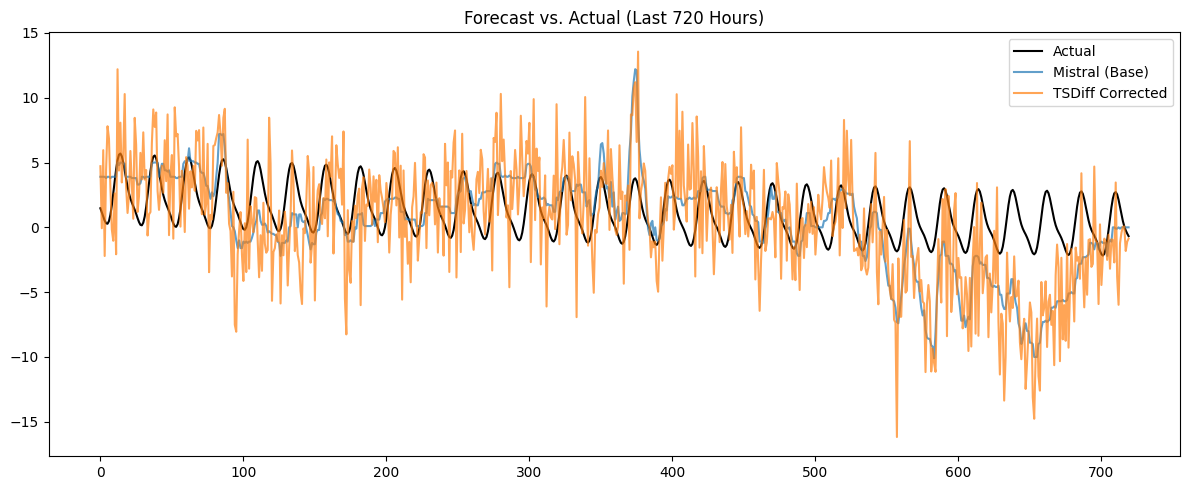

In [ ]:
# Training
EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_loader:
        x0 = batch[0].permute(0, 2, 1)
        noise = torch.randn_like(x0)
        t = torch.rand(x0.shape[0], 1, 1)
        xt = q_sample(x0, t, noise)
        pred_noise = model(xt, t)
        loss = criterion(pred_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.4f}")

# Load Mistral base predictions
mistral_preds = np.load("mistral_preds.npy")
next_month_actual = np.load("actual_values.npy")

# Normalize LLM output
y_pred = scaler.transform(mistral_preds.reshape(-1, 1))
y_pred = torch.tensor(y_pred, dtype=torch.float32).view(1, 1, -1).requires_grad_()

# Langevin Dynamics
model.eval()
η = 0.01
γ = 0.1
n_steps = 50

for _ in range(n_steps):
    noise = torch.randn_like(y_pred)
    with torch.enable_grad():
        loss = ((model(y_pred, torch.ones_like(y_pred) * 0.5) - noise) ** 2).mean()
        loss.backward()
        y_pred.data -= η * y_pred.grad + (2 * η * γ)**0.5 * noise
        y_pred.grad.zero_()

# Denormalize
refined_preds = scaler.inverse_transform(y_pred.detach().numpy().flatten().reshape(-1, 1)).flatten()

# Evaluate
def print_metrics(label, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\ {label} Metrics:")
    print(f"  RMSE : {rmse:.4f}")
    print(f"  MAE  : {mae:.4f}")
    print(f"  R²   : {r2:.4f}")

print_metrics("Mistral (Base)", next_month_actual, mistral_preds)
print_metrics("TSDiff Corrected", next_month_actual, refined_preds)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(next_month_actual, label="Actual", color="black")
plt.plot(mistral_preds, label="Mistral (Base)", alpha=0.7)
plt.plot(refined_preds, label="TSDiff Corrected", alpha=0.7)
plt.title("Forecast vs. Actual (Last 720 Hours)")
plt.legend()
plt.tight_layout()
plt.savefig("comparison_plot.png")
plt.show()


## Unconditional score based model with CNN-based denoiser

In [ ]:
# Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import math

In [ ]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Load and Normalize
df = pd.read_csv("weatherHistory.csv", parse_dates=["Formatted Date"])
df = df.sort_values("Formatted Date").reset_index(drop=True)
feature = "Temperature (C)"

scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[[feature]])

# Create training windows
WINDOW_SIZE = 720
X = np.array([data_scaled[i:i+WINDOW_SIZE] for i in range(len(data_scaled) - WINDOW_SIZE)])
X = torch.tensor(X, dtype=torch.float32).permute(0, 2, 1)
train_loader = DataLoader(TensorDataset(X), batch_size=64, shuffle=True)

# Define U-Net Denoising Model
class UNet1DDenoiser(nn.Module):
    def __init__(self, input_len=720):
        super().__init__()
        self.input_len = input_len

        # Positional encoding buffer
        pos = torch.arange(0, input_len).unsqueeze(1).float()
        dim = 64
        div_term = torch.exp(torch.arange(0, dim, 2).float() * (-np.log(10000.0) / dim))
        pe = torch.zeros(input_len, dim)
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        self.register_buffer("pos_encoding", pe.unsqueeze(0).permute(0, 2, 1))

        # Downsample layers
        self.down1 = nn.Sequential(nn.Conv1d(1 + dim, 32, 4, 2, 1), nn.ReLU())
        self.down2 = nn.Sequential(nn.Conv1d(32, 64, 4, 2, 1), nn.ReLU())

        # Bottleneck
        self.bottleneck = nn.Sequential(nn.Conv1d(64, 64, 3, 1, 1), nn.ReLU())

        # Upsample layers
        self.up1 = nn.Sequential(nn.ConvTranspose1d(64, 32, 4, 2, 1), nn.ReLU())
        self.up2 = nn.Sequential(nn.ConvTranspose1d(32, 16, 4, 2, 1), nn.ReLU())

        self.output_layer = nn.Conv1d(16, 1, 3, 1, 1)

    def forward(self, x, t):
        B, _, L = x.shape

        # Add positional encoding to input
        pos_encoded = self.pos_encoding.repeat(B, 1, 1)[:, :, :L]
        x = torch.cat([x, pos_encoded], dim=1)

        # Downsampling path
        d1 = self.down1(x)
        d2 = self.down2(d1)

        # Bottleneck
        b = self.bottleneck(d2)

        # Upsampling path
        u1 = self.up1(b)
        u1 = u1 + d1
        u2 = self.up2(u1)

        # Final prediction
        out = self.output_layer(u2)
        return out

model = UNet1DDenoiser(input_len=WINDOW_SIZE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Define noise injection
def q_sample(x0, t, noise):
    return x0 * (1 - t).sqrt() + noise * t.sqrt()

Epoch 1: Loss = 0.2170
Epoch 2: Loss = 0.1757
Epoch 3: Loss = 0.1711
Epoch 4: Loss = 0.1694
Epoch 5: Loss = 0.1681
Epoch 6: Loss = 0.1673
Epoch 7: Loss = 0.1670
Epoch 8: Loss = 0.1652
Epoch 9: Loss = 0.1641
Epoch 10: Loss = 0.1650
Epoch 11: Loss = 0.1642
Epoch 12: Loss = 0.1646
Epoch 13: Loss = 0.1630
Epoch 14: Loss = 0.1643
Epoch 15: Loss = 0.1632
Epoch 16: Loss = 0.1637
Epoch 17: Loss = 0.1623
Epoch 18: Loss = 0.1625
Epoch 19: Loss = 0.1622
Epoch 20: Loss = 0.1631
Epoch 21: Loss = 0.1632
Epoch 22: Loss = 0.1621
Epoch 23: Loss = 0.1610
Epoch 24: Loss = 0.1612
Epoch 25: Loss = 0.1615
Epoch 26: Loss = 0.1606
Epoch 27: Loss = 0.1603
Epoch 28: Loss = 0.1611
Epoch 29: Loss = 0.1608
Epoch 30: Loss = 0.1611
Epoch 31: Loss = 0.1611
Epoch 32: Loss = 0.1608
Epoch 33: Loss = 0.1611
Epoch 34: Loss = 0.1608
Epoch 35: Loss = 0.1608
Epoch 36: Loss = 0.1603
Epoch 37: Loss = 0.1601
Epoch 38: Loss = 0.1606
Epoch 39: Loss = 0.1610
Epoch 40: Loss = 0.1596
Epoch 41: Loss = 0.1601
Epoch 42: Loss = 0.1596
E

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔎 Mistral (Base) Metrics:
  RMSE : 3.1834
  MAE  : 2.4401
  R²   : -1.9058

🔎 TSDiff Corrected Metrics:
  RMSE : 4.2972
  MAE  : 3.3647
  R²   : -4.2949


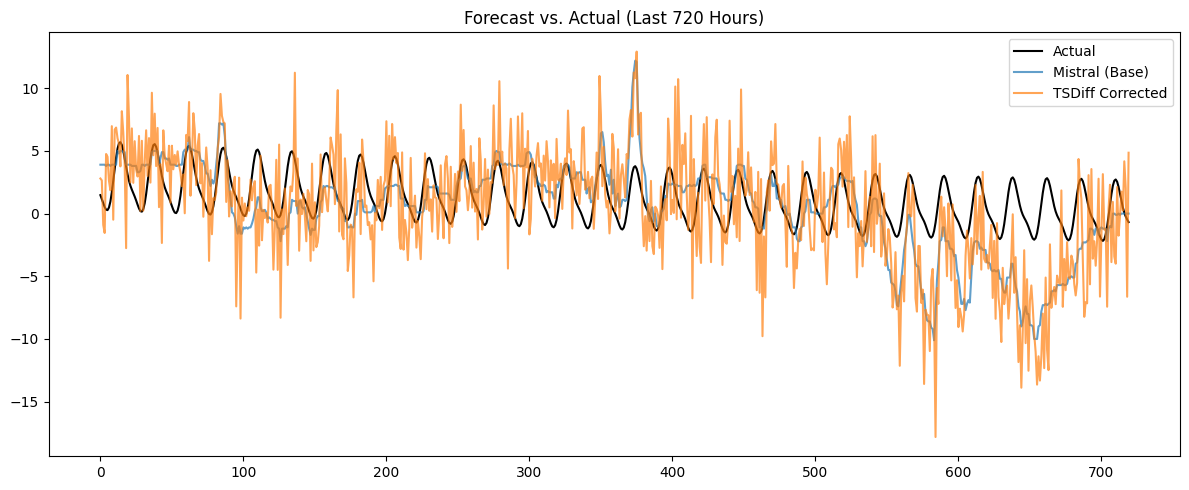

In [ ]:
# Train diffusion model
EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_loader:
        x0 = batch[0]
        noise = torch.randn_like(x0)
        t = torch.cos(torch.rand(x0.shape[0], 1, 1) * math.pi / 2) ** 2
        xt = q_sample(x0, t, noise)
        pred_noise = model(xt, t)
        loss = criterion(pred_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")

# Load Mistral predictions
mistral_preds = np.load("mistral_preds.npy")
next_month_actual = np.load("actual_values.npy")

# Langevin dynamics refinement
# Normalize Mistral predictions
y_pred = scaler.transform(mistral_preds.reshape(-1, 1))
y_pred = torch.tensor(y_pred, dtype=torch.float32).view(1, 1, -1).requires_grad_()

model.eval()
η = 0.01
γ = 0.1
n_steps = 50

for _ in range(n_steps):
    noise = torch.randn_like(y_pred)
    with torch.enable_grad():
        loss = ((model(y_pred, torch.ones_like(y_pred) * 0.5) - noise) ** 2).mean()
        loss.backward()
        y_pred.data -= η * y_pred.grad + (2 * η * γ)**0.5 * noise
        y_pred.grad.zero_()

# Denormalize corrected predictions
refined_preds = scaler.inverse_transform(y_pred.detach().numpy().reshape(-1, 1)).flatten()

# Evaluation
def print_metrics(label, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{label} Metrics:")
    print(f"  RMSE : {rmse:.4f}")
    print(f"  MAE  : {mae:.4f}")
    print(f"  R²   : {r2:.4f}")

print_metrics("Mistral (Base)", next_month_actual, mistral_preds)
print_metrics("TSDiff Corrected", next_month_actual, refined_preds)

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(next_month_actual, label="Actual", color="black")
plt.plot(mistral_preds, label="Mistral (Base)", alpha=0.7)
plt.plot(refined_preds, label="TSDiff Corrected", alpha=0.7)
plt.title("Forecast vs. Actual (Last 720 Hours)")
plt.legend()
plt.tight_layout()
plt.savefig("comparison_plot.png")
plt.show()

## Conditional Score based Model

In [ ]:
# Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [ ]:

# Set seed
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and normalize
df = pd.read_csv("weatherHistory.csv", parse_dates=["Formatted Date"])
df = df.sort_values("Formatted Date").reset_index(drop=True)
feature = "Temperature (C)"
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[[feature]])

# Define forecast range
CONTEXT = 8640
HORIZON = 720

# Extract last year's context
X = torch.tensor(
    data_scaled[-(CONTEXT + HORIZON):-HORIZON].reshape(1, CONTEXT, 1),
    dtype=torch.float32
).to(device)

# Conditional denoiser
class ConditionalDenoiser(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.LSTM(1, 32, batch_first=True)
        self.net = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 1, kernel_size=3, padding=1)
        )

    def forward(self, context, xt):
        if context.dim() > 3: context = context.squeeze(-1)
        if xt.dim() > 3: xt = xt.squeeze(-1)
        _, (h, _) = self.encoder(context)
        h = h.permute(1, 2, 0)
        xt = xt.permute(0, 2, 1)
        cond = h.expand(-1, -1, xt.shape[2])
        guided = cond + xt
        return self.net(guided).permute(0, 2, 1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔎 Mistral (Base) Metrics:
  RMSE : 3.1834
  MAE  : 2.4401
  R²   : -1.9058

🔎 TSDiff Corrected Metrics:
  RMSE : 3.1872
  MAE  : 2.4521
  R²   : -1.9128


<ipython-input-36-90118ac67d69>:114: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-36-90118ac67d69>:115: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("tsdiff_conditional_final.png")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


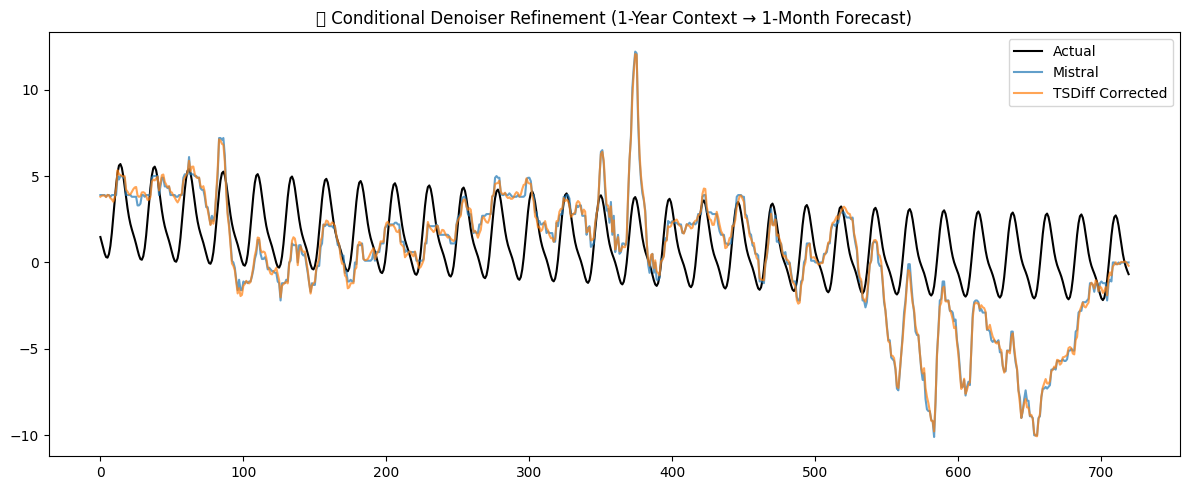

In [ ]:
# Load or define model
model = ConditionalDenoiser().to(device)
model.eval()

for module in model.modules():
    if isinstance(module, nn.LSTM):
        module.train()

# Load LLM predictions
mistral_preds = np.load("mistral_preds.npy")
next_month_actual = np.load("actual_values.npy")

# Normalize Mistral predictions and create tensor
xt = scaler.transform(mistral_preds.reshape(-1, 1))
xt_tensor = torch.tensor(xt.reshape(1, HORIZON, 1), dtype=torch.float32, device=device).detach().requires_grad_()

# Langevin Dynamics
η, γ, n_steps = 0.001, 0.1, 100
for _ in range(n_steps):
    noise = torch.randn_like(xt_tensor)
    with torch.enable_grad():
        loss = ((model(X, xt_tensor) - noise) ** 2).mean()
        loss.backward()
        with torch.no_grad():
            xt_tensor -= η * xt_tensor.grad + (2 * η * γ) ** 0.5 * noise
            xt_tensor.grad.zero_()

# Postprocess
refined_preds = scaler.inverse_transform(
    xt_tensor.detach().cpu().numpy().squeeze().reshape(-1, 1)
).flatten()

refined_preds = gaussian_filter1d(refined_preds, sigma=1.0)
α = 0.3
blended_preds = α * refined_preds + (1 - α) * mistral_preds[:HORIZON]

# Metrics
def print_metrics(label, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{label} Metrics:")
    print(f"  RMSE : {rmse:.4f}")
    print(f"  MAE  : {mae:.4f}")
    print(f"  R²   : {r2:.4f}")

print_metrics("Mistral (Base)", next_month_actual[:HORIZON], mistral_preds[:HORIZON])
print_metrics("TSDiff Corrected", next_month_actual[:HORIZON], blended_preds)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(next_month_actual[:HORIZON], label="Actual", color="black")
plt.plot(mistral_preds[:HORIZON], label="Mistral", alpha=0.7)
plt.plot(blended_preds, label="TSDiff Corrected", alpha=0.7)
plt.legend()
plt.title(" Conditional Denoiser Refinement (1-Year Context → 1-Month Forecast)")
plt.tight_layout()
plt.savefig("tsdiff_conditional_final.png")
plt.show()
